# Initial training

In [298]:
# import dependencies
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import tensorflow_model_optimization as tfmot
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
import matplotlib.pyplot as plt

In [299]:
# import model
pretrained_model = keras.applications.MobileNetV3Small(
    input_shape=(224, 224, 3), 
    weights='imagenet', 
    include_top=False,
    minimalistic=True,
    include_preprocessing=False,
)

In [300]:
# train and validation ds
data_dir = '/Users/USERNAME/Documents/Proge/fruit-detector-personal/ripeness/banana' # <-- put your own pathname here

batch_size = 16
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(val_ds.class_names)

Found 1343 files belonging to 3 classes.
Using 1075 files for training.
Found 1343 files belonging to 3 classes.
Using 268 files for validation.


In [301]:
# helper to one hot encode the labels
def one_hot_encode(image, label):
    one_hot_label = tf.one_hot(label, depth=num_classes)
    return image, one_hot_label

In [302]:
# apply to datasets
val_ds = val_ds.map(one_hot_encode)
train_ds = train_ds.map(one_hot_encode)

In [303]:
# helper functions to scale the pixel values from range [0, 256] to [-1, 1]
def preprocess_image(image, label=None):
    image = (image - 127.5) / 127.5
    if label is not None:
        return image, label
    return image

In [304]:
# apply to datasets
train_ds = train_ds.map(preprocess_image)
val_ds = val_ds.map(preprocess_image)

In [305]:
# AutoTune in TensorFlow is a feature that enables dynamic scheduling of parallel operations in a TensorFlow graph.
# It allows TensorFlow to automatically choose the best device for each operation, 
# depending on the available hardware and workload. 
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)

In [306]:
# turn off trainability in the pretrained model: we only want to train the extra output layers for now
pretrained_model.trainable = False

In [307]:
# layers applied after the pretrained model => these we are actually going to train
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=pretrained_model.input, outputs=predictions)

In [308]:
# Apply quantization-aware training to make the model smaller
quantize_model = tfmot.quantization.keras.quantize_model
q_aware_model = quantize_model(model)

# Compile the quantization-aware model
q_aware_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # <-- you can play around with this
                      metrics=['accuracy'])

In [309]:
# measure accuracy before training
loss0, accuracy0 = q_aware_model.evaluate(val_ds)

17/17 [==============================] - 16s 312ms/step - loss: 1.0914 - accuracy: 0.3731


In [310]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.09
initial accuracy: 0.37


In [311]:
# train the top layers of the model
initial_epochs = 10 # <-- you can play around with this
history = q_aware_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Epoch 1/10
68/68 [==============================] - 59s 567ms/step - loss: 1.1014 - accuracy: 0.3647 - val_loss: 1.0896 - val_accuracy: 0.3470
Epoch 2/10
68/68 [==============================] - 29s 385ms/step - loss: 1.0951 - accuracy: 0.3442 - val_loss: 1.0801 - val_accuracy: 0.3731
Epoch 3/10
68/68 [==============================] - 42s 585ms/step - loss: 1.0889 - accuracy: 0.3953 - val_loss: 1.0517 - val_accuracy: 0.3769
Epoch 4/10
68/68 [==============================] - 24s 351ms/step - loss: 0.7992 - accuracy: 0.6177 - val_loss: 0.6149 - val_accuracy: 0.7351
Epoch 5/10
68/68 [==============================] - 29s 419ms/step - loss: 0.5403 - accuracy: 0.7414 - val_loss: 0.4319 - val_accuracy: 0.8209
Epoch 6/10
68/68 [==============================] - 29s 417ms/step - loss: 0.5255 - accuracy: 0.7330 - val_loss: 0.4559 - val_accuracy: 0.7910
Epoch 7/10
68/68 [==============================] - 24s 342ms/step - loss: 0.4809 - accuracy: 0.7758 - val_loss: 0.3866 - val_accuracy: 0.8284

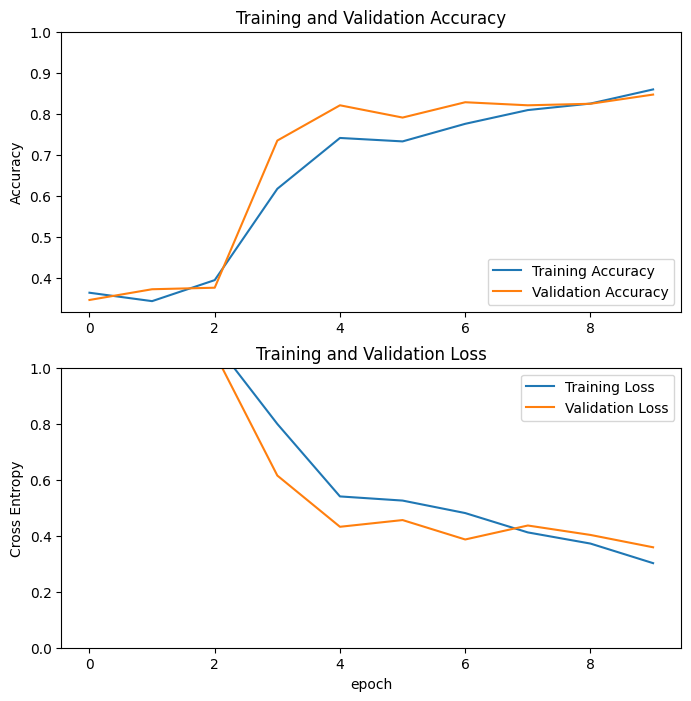

In [312]:
# display the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning

In [313]:
# Now we are also going to train the top layers of the pretrained model
pretrained_model.trainable = True

fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in pretrained_model.layers[:fine_tune_at]:
    layer.trainable = False

In [314]:
# compile the model again with a different optimizer
q_aware_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
              metrics=['accuracy'])

In [315]:
# train again
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = q_aware_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/15
68/68 [==============================] - 48s 519ms/step - loss: 0.2801 - accuracy: 0.8605 - val_loss: 0.3944 - val_accuracy: 0.8545
Epoch 11/15
68/68 [==============================] - 24s 345ms/step - loss: 0.2420 - accuracy: 0.8865 - val_loss: 0.3369 - val_accuracy: 0.8731
Epoch 12/15
68/68 [==============================] - 23s 340ms/step - loss: 0.2193 - accuracy: 0.8949 - val_loss: 0.4071 - val_accuracy: 0.8694
Epoch 13/15
68/68 [==============================] - 23s 341ms/step - loss: 0.1890 - accuracy: 0.9023 - val_loss: 0.6689 - val_accuracy: 0.7612
Epoch 14/15
68/68 [==============================] - 24s 347ms/step - loss: 0.1767 - accuracy: 0.9116 - val_loss: 0.6277 - val_accuracy: 0.8545
Epoch 15/15
68/68 [==============================] - 24s 343ms/step - loss: 0.1578 - accuracy: 0.9191 - val_loss: 0.5004 - val_accuracy: 0.8769


In [318]:
# add data so we can graph before vs after
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

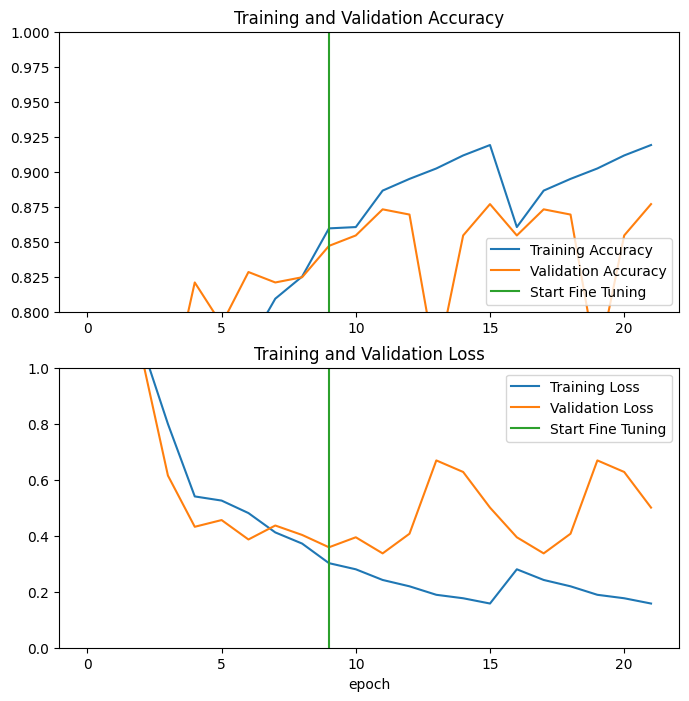

In [319]:
# display the training progress
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [320]:
# to save the model uncomment and run next line
#q_aware_model.save('/Users/USERNAME/Documents/Proge/fruit-detector/server/models/ripeness')

### Make predictions

In [321]:
from tensorflow.keras.preprocessing import image

img = image.load_img('/Users/USERNAME/Downloads/IMG_4006.jpg', target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Reshape the image to match the batch size of your model
img_batch = np.expand_dims(img_array, axis=0)

# Preprocess
img_batch = preprocess_image(img_batch, None)

# Predict
predictions = q_aware_model.predict(img_batch)

# Convert predictions to class labels
class_labels = np.argmax(predictions, axis=1)

# Display class
class_names[class_labels[0]]

1/1 [==============================] - 1s 1s/step


'overripe'

# Convert into TF lite

In [322]:
# uncomment next line to get some info about the converter
# print(help(tf.lite.TFLiteConverter))

In [323]:
# convert model
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/vn/vg9g17yx0hgcwsgfx9z89kpc0000gn/T/tmpaut55e5n/assets


INFO:tensorflow:Assets written to: /var/folders/vn/vg9g17yx0hgcwsgfx9z89kpc0000gn/T/tmpaut55e5n/assets
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-04-27 16:25:14.091979: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-04-27 16:25:14.092190: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.


In [324]:
# Save the TFLite model to a file
with open("optimized_model.tflite", "wb") as f:
    f.write(quantized_tflite_model)

### Make predictions with TF lite model

In [252]:
from tensorflow.keras.preprocessing import image

# Load the TFLite model from the file
tflite_model_file = "optimized_model.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)

# Allocate tensors
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Preprocess the input image
img = image.load_img('/Users/USERNAME/Downloads/IMG_4006.jpg', target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
preprocessed_img_batch = preprocess_image(img_batch)

# Set the input tensor for the interpreter
interpreter.set_tensor(input_details[0]['index'], preprocessed_img_batch)

# Invoke the interpreter to run the prediction
interpreter.invoke()

# Extract the output tensor and post-process the results
output_data = interpreter.get_tensor(output_details[0]['index'])
class_labels = np.argmax(output_data, axis=1)
class_name = class_names[class_labels[0]]

print("Predicted class:", class_name)

Predicted class: overripe
